In [146]:
import sys
import pandas as pd 
import numpy as np 
import seaborn as sns
import tensorflow.keras 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Lambda, dot, Activation, concatenate,  Layer

In [147]:
dfstocks = pd.read_csv('../../../data/S&PFinanceData2020.csv',parse_dates = True)
dftweets = pd.read_csv('../../../data/stocktwits_SPXclassified.csv', parse_dates = True)
dftweets.head()

,Unnamed: 0,symbol,message,datetime,user,message_id,sentiment
0,0,SPX,$spy $spx looking for more green tomorrow but ...,2020-12-16T21:15:21Z,226994,264863118,NaN
1,1,SPX,$SPY Can just use this Headline for the next 4...,2020-12-16T21:11:34Z,1078695,264861500,0.0
2,2,SPX,"$SPX +0.2%, $NDX +0.6% \nAll about FOMC and St...",2020-12-16T21:07:06Z,322291,264859501,NaN
3,3,SPX,S&amp;P 500 Stocks At X-Day High [15-Dec]:\n\n...,2020-12-16T21:00:45Z,313661,264856112,NaN
4,4,SPX,$SPY $SPX Wilshire 5000 Broad Measure Cycle is...,2020-12-16T21:00:20Z,21210,264855893,1.0


In [148]:
def sentimentIndex(x):
    return np.log( (1 + x[1]) / (1 + x[0]))

In [149]:
dftweets = dftweets.dropna()
dftweets['sentiment'] = dftweets['sentiment'].astype('int')
rowsdifference = dfstocks.iloc[:, 5]
dfstocks['Difference'] = rowsdifference.diff()
dfstocks['Date'] = pd.to_datetime(dfstocks['Date'])
dfstocks['Difference'].iloc[0] = 0
dftweets['datetime'] = pd.to_datetime(dftweets['datetime'])
dftweets['datetime'] = pd.to_datetime(dftweets['datetime'].dt.date)
dftweets = dftweets[(dftweets['datetime']>= "2020-01-01") & (dftweets['datetime']< "2021-01-01")]
dftweets = dftweets.pivot_table(index='datetime',columns='sentiment', aggfunc='size')
print(dftweets[1])
dftweets['sentimentIndex'] = dftweets.apply(sentimentIndex, axis = 1)

dftweets.sort_values('datetime', inplace=True, ascending=True)
#rowsdiff2 = dftweets['sentimentIndex']
#dfstocks.set_index('Date').diff()
#rowsdiff2.diff()
#dftweets['Differencetweets'] = rowsdiff2
#dftweets['Differencetweets'].iloc[0] = 0


merged = pd.merge(left=dftweets, left_on='datetime',
         right=dfstocks, right_on='Date')
merged_sim  = merged[ ['Open', 'High', 'Low', 'Adj Close', 'Volume','sentimentIndex','Close']]
merged = merged[1:]

merged.head()

datetime
2020-01-01     4
2020-01-02    23
2020-01-03    15
2020-01-04     2
2020-01-05     2
              ..
2020-12-12    17
2020-12-13    17
2020-12-14    29
2020-12-15    19
2020-12-16    17
Name: 1, Length: 351, dtype: int64


,0,1,sentimentIndex,Date,Open,High,Low,Close,Adj Close,Volume,Difference
1,58,15,-1.304949,2020-01-03,3226.360107,3246.149902,3222.340088,3234.850098,3234.850098,3461290000,-23.000000
2,14,13,-0.068993,2020-01-06,3217.550049,3246.840088,3214.639893,3246.280029,3246.280029,3674070000,11.429932
3,23,19,-0.182322,2020-01-07,3241.860107,3244.909912,3232.429932,3237.179932,3237.179932,3420380000,-9.100098
4,22,35,0.448025,2020-01-08,3238.590088,3267.070068,3236.669922,3253.050049,3253.050049,3720890000,15.870117
5,21,15,-0.318454,2020-01-09,3266.030029,3275.580078,3263.669922,3274.699951,3274.699951,3638390000,21.649902


In [150]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


## One-Day Lag Time

In [151]:
n_days = 1
n_features = 7
dataset = merged_sim.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = series_to_supervised(dataset, n_days,1)

droplist = []
for i in range(n_features*n_days, n_features*n_days + 6):
    droplist.append(i)
print(droplist)
dataset.drop(dataset.columns[droplist], axis = 1, inplace = True)
dataset

[7, 8, 9, 10, 11, 12]


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var7(t)
1,0.674048,0.678216,0.697309,0.696624,0.108486,0.577950,0.696624,0.680923
2,0.661111,0.669722,0.688497,0.680923,0.108971,0.240787,0.680923,0.688726
3,0.654886,0.670211,0.683352,0.688726,0.142928,0.591807,0.688726,0.682513
4,0.672063,0.668844,0.695238,0.682513,0.102443,0.559621,0.682513,0.693347
5,0.669752,0.684542,0.698071,0.693347,0.150400,0.738643,0.693347,0.708127
...,...,...,...,...,...,...,...,...
238,1.000000,1.000000,0.981272,0.979909,0.388030,0.373091,0.979909,0.976687
239,0.966897,0.975986,0.971010,0.976687,0.293604,0.017883,0.976687,0.973520
240,0.964742,0.967074,0.963139,0.973520,0.253533,0.367536,0.973520,0.962617
241,0.978301,0.989530,0.971451,0.962617,0.289882,0.663182,0.962617,0.994791


In [152]:
train_size = int(merged.shape[0]*0.7)

n_obs = n_days * n_features
values = dataset.values
train, test =  values[0:train_size, :], values[train_size:len(values), :]
train_X, train_y = train[:,:n_obs], train[:,-n_features]
test_X, test_y = test[:,:n_obs], test[:,-n_features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

In [153]:
batch_size = 32
time_steps = 1
input_dim = (train_X.shape[1], train_X.shape[2])
#np.random.seed(420)
epochs = 50

In [154]:
#https://github.com/philipperemy/keras-attention-mechanism
class Attention(Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __call__(self, hidden_states):
        hidden_size = int(hidden_states.shape[2])
        score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
        h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
        score = dot([score_first_part, h_t], [2, 1], name='attention_score')
        attention_weights = Activation('softmax', name='attention_weight')(score)
        context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
        pre_activation = concatenate([context_vector, h_t], name='attention_output')
        attention_vector = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
        return attention_vector

Epoch 1/50
6/6 [==============================] - 2s 98ms/step - loss: 0.1717 - accuracy: 0.0037 - val_loss: 0.0028 - val_accuracy: 0.0137
Epoch 2/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0184 - accuracy: 0.0017 - val_loss: 0.0233 - val_accuracy: 0.0137
Epoch 3/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0152 - accuracy: 0.0052 - val_loss: 0.0201 - val_accuracy: 0.0137
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0087 - accuracy: 0.0026 - val_loss: 0.0236 - val_accuracy: 0.0137
Epoch 5/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0051 - accuracy: 0.0074 - val_loss: 0.0014 - val_accuracy: 0.0137
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0024 - accuracy: 0.0074 - val_loss: 0.0019 - val_accuracy: 0.0137
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0015 - accuracy: 0.0026 - val_loss: 0.0039 - val_accuracy: 0.0137
Epoch 8/50
6/6 [===========

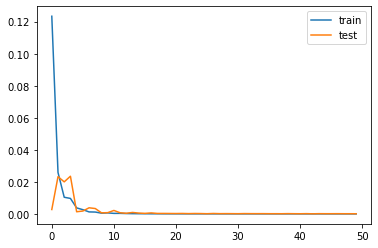

In [155]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences = True))
model.add(Attention())
model.add(Dense(1, activation = 'relu'))


model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_X, train_y,
                validation_data = (test_X, test_y),
                batch_size=batch_size,
                epochs=epochs)
            
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [156]:
#model.save('../../models/SALSTMLag1.h5')

In [157]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, (-1 * n_features + 1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [158]:
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, (-1 * n_features + 1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [159]:
inv_yhat

array([3561.2708, 3503.5713, 3432.8616, 3357.5005, 3390.803 , 3374.8884,
       3344.888 , 3378.7449, 3403.5918, 3405.8247, 3355.883 , 3354.6582,
       3284.1282, 3307.8057, 3282.7817, 3252.4275, 3275.7537, 3345.3342,
       3344.813 , 3368.0742, 3383.8032, 3352.0083, 3392.3599, 3390.7812,
       3406.177 , 3438.267 , 3469.7485, 3516.5854, 3518.476 , 3501.3735,
       3469.712 , 3493.8708, 3451.4463, 3444.2854, 3440.3047, 3443.083 ,
       3454.061 , 3414.2993, 3398.3162, 3313.6743, 3307.5002, 3284.4485,
       3309.5276, 3360.794 , 3438.5298, 3508.5635, 3509.7122, 3589.787 ,
       3550.3535, 3566.956 , 3552.1643, 3576.148 , 3617.007 , 3611.3264,
       3595.7727, 3570.7766, 3568.1921, 3571.89  , 3626.1924, 3628.7905,
       3626.5876, 3629.2334, 3659.2366, 3660.1128, 3668.341 , 3683.5505,
       3683.1294, 3682.2397, 3685.788 , 3664.1882, 3652.6228, 3656.3953,
       3675.05  ], dtype=float32)

## Regular LSTM Baseline

In [160]:
merged_simbase  = merged_sim[ ['Open', 'High', 'Low', 'Adj Close', 'Volume','Close']]
n_days = 1
n_features = 6
dataset = merged_simbase.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = series_to_supervised(dataset, n_days,1)

droplist = []
for i in range(n_features*n_days, n_features*n_days + 5):
    droplist.append(i)
print(droplist)
dataset.drop(dataset.columns[droplist], axis = 1, inplace = True)
dataset

[6, 7, 8, 9, 10]


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var6(t)
1,0.674048,0.678216,0.697309,0.696624,0.108486,0.696624,0.680923
2,0.661111,0.669722,0.688497,0.680923,0.108971,0.680923,0.688726
3,0.654886,0.670211,0.683352,0.688726,0.142928,0.688726,0.682513
4,0.672063,0.668844,0.695238,0.682513,0.102443,0.682513,0.693347
5,0.669752,0.684542,0.698071,0.693347,0.150400,0.693347,0.708127
...,...,...,...,...,...,...,...
238,1.000000,1.000000,0.981272,0.979909,0.388030,0.979909,0.976687
239,0.966897,0.975986,0.971010,0.976687,0.293604,0.976687,0.973520
240,0.964742,0.967074,0.963139,0.973520,0.253533,0.973520,0.962617
241,0.978301,0.989530,0.971451,0.962617,0.289882,0.962617,0.994791


In [161]:
train_size = int(merged.shape[0]*0.7)

n_obs = n_days * n_features
values = dataset.values
train, test =  values[0:train_size, :], values[train_size:len(values), :]
train_X, train_y = train[:,:n_obs], train[:,-n_features]
test_X, test_y = test[:,:n_obs], test[:,-n_features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

In [162]:
batch_size = 32
epochs = 50

In [163]:
modelbase = Sequential()
modelbase.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
modelbase.add(Dense(1, activation = 'relu'))
modelbase.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

history = modelbase.fit(train_X, train_y,
                validation_data = (test_X, test_y),
                batch_size=batch_size,
                epochs=epochs)
# plt.plot(history.history['loss'], label = 'train')
# plt.plot(history.history['val_loss'], label = 'test')
# plt.legend()
# plt.show()

Epoch 1/50
6/6 [==============================] - 2s 88ms/step - loss: 0.3169 - accuracy: 0.0119 - val_loss: 0.5054 - val_accuracy: 0.0000e+00
Epoch 2/50
6/6 [==============================] - 0s 13ms/step - loss: 0.2174 - accuracy: 0.0017 - val_loss: 0.3090 - val_accuracy: 0.0000e+00
Epoch 3/50
6/6 [==============================] - 0s 12ms/step - loss: 0.1141 - accuracy: 0.0119 - val_loss: 0.1600 - val_accuracy: 0.0137
Epoch 4/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0556 - accuracy: 0.0037 - val_loss: 0.0617 - val_accuracy: 0.0137
Epoch 5/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0179 - accuracy: 0.0037 - val_loss: 0.0131 - val_accuracy: 0.0137
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0050 - accuracy: 0.0119 - val_loss: 6.7871e-04 - val_accuracy: 0.0137
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0063 - accuracy: 0.0037 - val_loss: 5.9743e-04 - val_accuracy: 0.0137
Epoch 8/50


In [164]:
yhatbase = modelbase.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
inv_yhatbase = np.concatenate((yhatbase, test_X[:, (-1 * n_features + 1):]), axis=1)
inv_yhatbase = scaler.inverse_transform(inv_yhatbase)
inv_yhatbase = inv_yhatbase[:,0]

In [165]:
#modelbase.save('../../models/LSTMBASE.h5')

In [166]:
inv_yhatbase

array([3563.3613, 3485.1743, 3425.5413, 3347.9102, 3395.282 , 3369.3228,
       3348.6255, 3383.6323, 3405.3396, 3396.3103, 3354.8503, 3313.8486,
       3274.9822, 3310.4875, 3273.2214, 3247.272 , 3284.007 , 3351.0315,
       3347.5188, 3359.7732, 3383.525 , 3350.3076, 3397.462 , 3382.0994,
       3410.662 , 3442.7195, 3471.6885, 3526.2605, 3519.2446, 3499.8447,
       3472.4663, 3486.8518, 3452.2852, 3448.7664, 3441.8306, 3444.5537,
       3462.9832, 3410.986 , 3398.8066, 3296.4622, 3300.8555, 3276.1348,
       3309.667 , 3362.9973, 3433.903 , 3499.2727, 3501.246 , 3543.5735,
       3527.6372, 3564.4548, 3537.9077, 3568.8228, 3607.8787, 3601.7708,
       3576.6514, 3567.3833, 3563.0647, 3565.6177, 3606.1482, 3622.3872,
       3641.2966, 3605.7217, 3649.2815, 3653.9988, 3660.0015, 3680.3325,
       3684.4258, 3690.1033, 3675.2942, 3658.3447, 3652.4075, 3656.3953,
       3678.4675], dtype=float32)

## Evaluation Metrics

In [167]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score 

#FOR SA_LSTM
print("=====SAA LSTM=====")
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y,inv_yhat)
r2 = r2_score(inv_y, inv_yhat)


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(inv_y,inv_yhat)



print("RMSE: " , rmse)
print("MAE: ", mae)
print("R2: ", r2)
print("MAPE: ", mape)

#FOR BASE LSTM
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhatbase))
mae = mean_absolute_error(inv_y,inv_yhatbase)
r2 = r2_score(inv_y, inv_yhatbase)


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(inv_y,inv_yhatbase)


print("=====BASE LSTM=====")
print("RMSE: " , rmse)
print("MAE: ", mae)
print("R2: ", r2)
print("MAPE: ", mape)

=====SAA LSTM=====
RMSE:  19.54936
MAE:  15.484994
R2:  0.9757797332798022
MAPE:  0.4445204045623541
=====BASE LSTM=====
RMSE:  25.823793
MAE:  20.036722
R2:  0.9577376258734381
MAPE:  0.5731571465730667


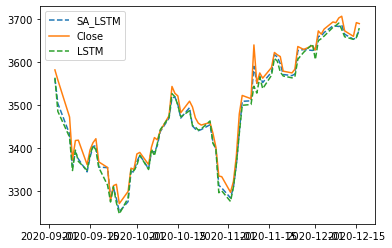

In [168]:
x = merged['Date'][train_size:]
#plt.plot(merged['Date'][0:train_size], history, label = "History")
plt.plot(x,inv_yhat, label = "SA_LSTM", ls = '--')
plt.plot(x,inv_y, label = "Close")
plt.plot(x,inv_yhatbase,label = "LSTM", ls = '--')
#plt.plot(x, merged['Close'][train_size:len(merged)-2], label = "Close")
plt.legend()


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0016  , p=0.9676  , df_denom=237, df_num=1
ssr based chi2 test:   chi2=0.0017  , p=0.9674  , df=1
likelihood ratio test: chi2=0.0017  , p=0.9674  , df=1
parameter F test:         F=0.0016  , p=0.9676  , df_denom=237, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0119  , p=0.3651  , df_denom=234, df_num=2
ssr based chi2 test:   chi2=2.0671  , p=0.3557  , df=2
likelihood ratio test: chi2=2.0582  , p=0.3573  , df=2
parameter F test:         F=1.0119  , p=0.3651  , df_denom=234, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3090  , p=0.8189  , df_denom=231, df_num=3
ssr based chi2 test:   chi2=0.9551  , p=0.8121  , df=3
likelihood ratio test: chi2=0.9531  , p=0.8126  , df=3
parameter F test:         F=0.3090  , p=0.8189  , df_denom=231, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4978  , p=0.7374  

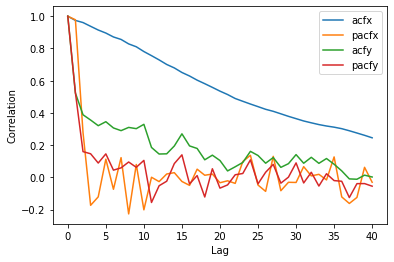

In [169]:
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests
#1 gives highest granger causality
rowsdiff2 = merged['sentimentIndex']
rowsdiff2 = rowsdiff2.diff()
merged['Differencetweets'] = rowsdiff2
merged['Differencetweets'].iloc[0] = 0
res = grangercausalitytests(merged[['Close','sentimentIndex']][1:], maxlag=15)
acfx= acf(merged_sim[['Close']])
pacfx = pacf(merged_sim[['Close']])
acfy = acf(merged_sim[['sentimentIndex']])
pacfy = pacf(merged_sim[['sentimentIndex']])
plt.plot(acfx, label = "acfx")
plt.plot(pacfx, label = "pacfx")
plt.plot(acfy, label = "acfy")
plt.plot(pacfy, label = "pacfy")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.legend()

In [172]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(merged['Differencetweets'][1:])

Results of Dickey-Fuller Test:
Test Statistic                  -1.358784
p-value                          0.601868
#Lags Used                       9.000000
Number of Observations Used    231.000000
Critical Value (1%)             -3.458980
Critical Value (5%)             -2.874135
Critical Value (10%)            -2.573482
dtype: float64


In [63]:
dfstocks

,Date,Open,High,Low,Close,Adj Close,Volume,Difference
0,2020-01-02,3244.669922,3258.139893,3235.530029,3257.850098,3257.850098,3458250000,0.000000
1,2020-01-03,3226.360107,3246.149902,3222.340088,3234.850098,3234.850098,3461290000,-23.000000
2,2020-01-06,3217.550049,3246.840088,3214.639893,3246.280029,3246.280029,3674070000,11.429932
3,2020-01-07,3241.860107,3244.909912,3232.429932,3237.179932,3237.179932,3420380000,-9.100098
4,2020-01-08,3238.590088,3267.070068,3236.669922,3253.050049,3253.050049,3720890000,15.870117
...,...,...,...,...,...,...,...,...
241,2020-12-15,3666.409912,3695.290039,3659.620117,3694.620117,3694.620117,4360280000,47.130127
242,2020-12-16,3696.250000,3711.270020,3688.570068,3701.169922,3701.169922,4056950000,6.549805
243,2020-12-17,3713.649902,3725.120117,3710.870117,3722.479980,3722.479980,4184930000,21.310059
244,2020-12-18,3722.389893,3726.699951,3685.840088,3709.409912,3709.409912,7068340000,-13.070068
